# Empirical extension
This notebook extends the (empirical) results from the paper "[Feature learning in neural networks and kernel machines that recursively learn features](https://arxiv.org/abs/2212.13881)". The four main directions of explorations are:
1. [__Feature learning__](#sec1): where and how are features learned?
2. [__Gradientless optimization__](#sec2): Do different optimization methods have effects on the learned features?
3. [__RFM__ _(possible)_ __improvements__](#sec3): How could RFMs be improved?
4. [__Structural constraints__](#sec4) (e.g. equivariance): What happens for models which constraint the feature matrix, such as CNNs?


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms

plt.ion()

from IPython.display import Markdown

from methods import rfm, nn
from utils.misc import suppress_stdout
from utils.visualize import pearson

dataset_path = os.path.join(os.getcwd(), "datasets")
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)


SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)


def printmd(string):
    display(Markdown(string))

/home/ggalletti/git/recursive_feature_machines_praktikum/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.datasets import STL10, MNIST, CelebA
from torch.utils.data import Subset

from utils.data import split, get_celeba_balanced_data

N_SAMPLES = 6000
SIZE = 16
CELEBA_SIZE = 32

with suppress_stdout():
    stl10_transform = transforms.Compose(
        [
            transforms.Resize([SIZE, SIZE]),
            transforms.Grayscale(),
            transforms.ToTensor(),
            torch.flatten,
        ]
    )
    # classify vehicles vs animals
    stl10_to_binary = (
        lambda y: torch.tensor([1, 0]) if y in [0, 2, 6, 8, 9] else torch.tensor([0, 1])
    )
    stl10_dataset_full = STL10(
        dataset_path,
        split="train",
        transform=stl10_transform,
        download=True,
        target_transform=stl10_to_binary,
    )
    stl10_dataset = Subset(
        stl10_dataset_full, np.random.choice(len(stl10_dataset_full), N_SAMPLES)
    )
    stl10_trainset, stl10_valset = split(stl10_dataset, p=0.9)

    stl10_testset = STL10(
        dataset_path,
        split="test",
        transform=stl10_transform,
        download=True,
        target_transform=stl10_to_binary,
    )

    mnist_transform = transforms.Compose(
        [
            transforms.Resize([SIZE, SIZE]),
            transforms.ToTensor(),
            torch.flatten,
        ]
    )
    # classify vehicles vs animals
    mnist_to_binary = (
        lambda y: torch.tensor([0, 1]) if y % 2 == 0 else torch.tensor([1, 0])
    )
    mnist_dataset_full = MNIST(
        dataset_path,
        train=True,
        transform=mnist_transform,
        download=True,
        target_transform=mnist_to_binary,
    )
    mnist_dataset = Subset(
        mnist_dataset_full, np.random.choice(len(mnist_dataset_full), N_SAMPLES)
    )
    mnist_trainset, mnist_valset = split(mnist_dataset, p=0.9)

    mnist_testset = MNIST(
        dataset_path,
        train=True,
        transform=mnist_transform,
        download=True,
        target_transform=mnist_to_binary,
    )

    celeba_transform = transforms.Compose(
        [
            transforms.Resize([CELEBA_SIZE, CELEBA_SIZE]),
            transforms.ToTensor(),
            torch.flatten,
        ]
    )
    celeba_dataset_full = CelebA(
        root=dataset_path,
        split="train",
        transform=celeba_transform,
        download=True,
    )
    celeba_testset_full = CelebA(
        root=dataset_path,
        split="test",
        transform=celeba_transform,
        download=True,
    )

    celeba_dataset = get_celeba_balanced_data(
        celeba_dataset_full, target="glasses", num_samples=50000, norm=False
    )
    celeba_trainset, celeba_valset = split(celeba_dataset, p=0.9)
    celeba_testset = get_celeba_balanced_data(
        celeba_testset_full, target="glasses", num_samples=10000, norm=False
    )

    celeba_young_dataset = get_celeba_balanced_data(
        celeba_dataset_full, target="young", num_samples=5000, norm=False
    )
    celeba_young_trainset, celeba_young_valset = split(celeba_young_dataset, p=0.9)
    celeba_young_testset = get_celeba_balanced_data(
        celeba_testset_full, target="young", num_samples=1000, norm=False
    )


DATALOADERS = {}

stl10_trainloader = DataLoader(stl10_trainset, batch_size=128, shuffle=True)
stl10_valloader = DataLoader(stl10_valset, batch_size=100, shuffle=False)
stl10_testloader = DataLoader(stl10_testset, batch_size=512, shuffle=False)
DATALOADERS["stl10"] = (stl10_trainloader, stl10_valloader, stl10_testloader)

mnist_trainloader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
mnist_valloader = DataLoader(mnist_valset, batch_size=100, shuffle=False)
mnist_testloader = DataLoader(mnist_testset, batch_size=512, shuffle=False)
DATALOADERS["mnist"] = (mnist_trainloader, mnist_valloader, mnist_testloader)

celeba_trainloader = DataLoader(celeba_trainset, batch_size=128, shuffle=True)
celeba_valloader = DataLoader(celeba_valset, batch_size=100, shuffle=False)
celeba_testloader = DataLoader(celeba_testset, batch_size=512, shuffle=False)
DATALOADERS["celeba"] = (celeba_trainloader, celeba_valloader, celeba_testloader)

celeba_young_trainloader = DataLoader(
    celeba_young_trainset, batch_size=128, shuffle=True
)
celeba_young_valloader = DataLoader(celeba_young_valset, batch_size=100, shuffle=False)
celeba_young_testloader = DataLoader(
    celeba_young_testset, batch_size=512, shuffle=False
)

### STL10 - vehicles vs animals
Train size: 4500, eval size: 8000

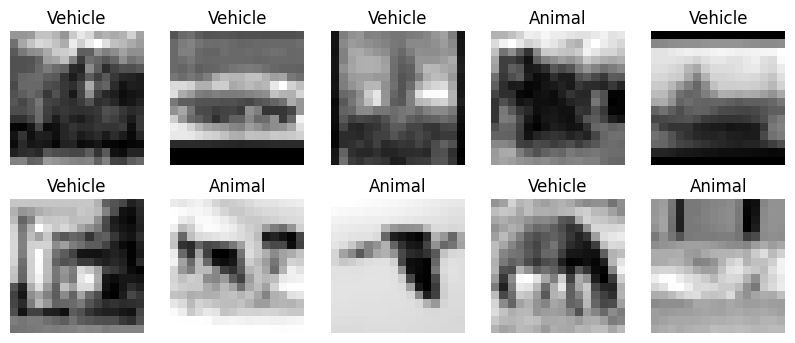

In [ ]:
printmd(
    "### STL10 - vehicles vs animals\n"
    f"Train size: {len(stl10_trainset)}, eval size: {len(stl10_testset)}"
)


fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, (img, label) in enumerate(stl10_trainset[:10]):
    axs[i // 5, i % 5].imshow(img.reshape(1, SIZE, SIZE).permute(1, 2, 0), cmap="gray")
    axs[i // 5, i % 5].set_title(["Vehicle", "Animal"][label.argmax()])
    axs[i // 5, i % 5].axis("off")
plt.show()

### MNIST - odd vs even
Train size: 5400, eval size: 60000

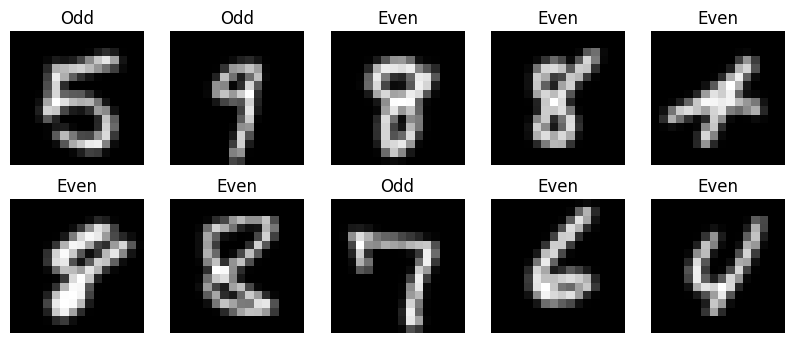

In [ ]:
printmd(
    "### MNIST - odd vs even\n"
    f"Train size: {len(mnist_trainset)}, "
    f"eval size: {len(mnist_testset)}"
)


fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, (img, label) in enumerate(mnist_trainset[:10]):
    axs[i // 5, i % 5].imshow(img.reshape(1, SIZE, SIZE).permute(1, 2, 0), cmap="gray")
    axs[i // 5, i % 5].set_title(["Odd", "Even"][label.argmax()])
    axs[i // 5, i % 5].axis("off")
plt.show()

### CelebA - glasses
Train size: 5850, eval size: 1272

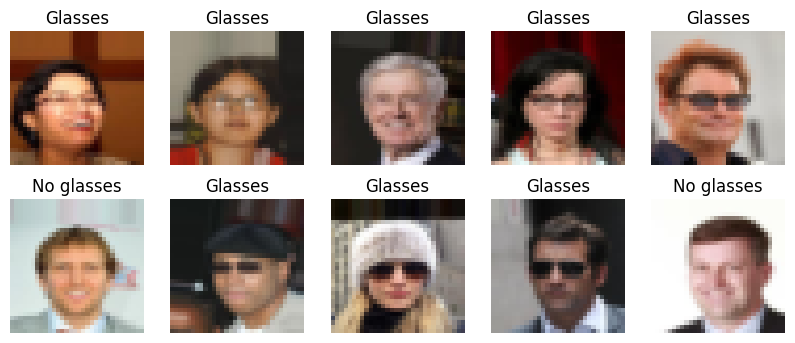

### CelebA - young
Train size: 5400, eval size: 1000

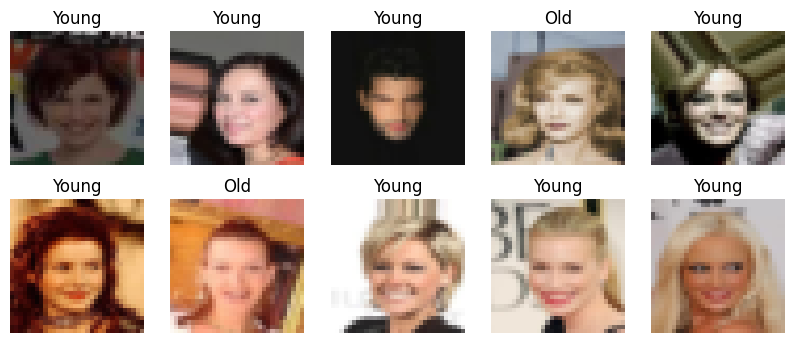

In [ ]:
printmd(
    "### CelebA - glasses\n"
    f"Train size: {len(celeba_trainset)}, eval size: {len(celeba_testset)}"
)
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, (img, label) in enumerate(celeba_trainset[:10]):
    axs[i // 5, i % 5].imshow(img.reshape(3, SIZE * 2, SIZE * 2).permute(1, 2, 0))
    axs[i // 5, i % 5].set_title(["No glasses", "Glasses"][label.argmax()])
    axs[i // 5, i % 5].axis("off")
plt.show()

printmd(
    "### CelebA - young\n"
    f"Train size: {len(celeba_young_trainset)}, eval size: {len(celeba_young_testset)}"
)
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, (img, label) in enumerate(celeba_young_trainset[:10]):
    axs[i // 5, i % 5].imshow(img.reshape(3, SIZE * 2, SIZE * 2).permute(1, 2, 0))
    axs[i // 5, i % 5].set_title(["Old", "Young"][label.argmax()])
    axs[i // 5, i % 5].axis("off")
plt.show()

## 1. Feature learning
This sections performs a few diverse tests to see the behaviour of the feature learning process, namely:
- __Feature swap__: train an MLP and an RFM, swap feature matrices and evaluate without retraining. __PS it is not possible to set the first MLP layer to the RFM feature matrix because the decomposition problem is underdetermined.__
- __Feature destroy__: train an MLP and an RFM, destroy feature matrices and evaluate without retraining.
- __Layer dropout__: force subsequent MLP layers to learn features by dropping out __the first layer__ during training.
- ~~__Tiny features__: feature matrix as the latent space of an autoencoder, way smaller than $(W \cdot H \cdot C)^2$.~~


<a id='sec1'></a>

In [ ]:
dim = next(iter(stl10_trainloader))[0].shape[1]

mlp, mse_mlp, acc_mlp, _ = nn.train(
    stl10_trainloader, stl10_valloader, stl10_testloader, width=dim, num_epochs=5
)
mse_mlp_swap, acc_mlp_swap = nn.val_step(mlp.set_M(mlp.M, "cholesky"), stl10_testloader)
printmd(f"ground truth -> MLP: MSE={mse_mlp:.4f}, ACC={acc_mlp:.2f}")
printmd(f"cholesky -> MLP (swap): MSE={mse_mlp_swap:.4f}, ACC={acc_mlp_swap:.2f}")
mse_mlp_swap, acc_mlp_swap = nn.val_step(mlp.set_M(mlp.M, "eig"), stl10_testloader)
printmd(f"matrix sqrt -> MLP (swap): MSE={mse_mlp_swap:.4f}, ACC={acc_mlp_swap:.2f}")

ground truth -> MLP: MSE=0.2092, ACC=69.96

cholesky -> MLP (swap): MSE=0.3200, ACC=50.25

matrix sqrt -> MLP (swap): MSE=0.4302, ACC=49.94

In [ ]:
dim = next(iter(stl10_trainloader))[0].shape[1]
M_rfm, mse_rfm, acc_rfm, _ = rfm.train(stl10_trainloader, stl10_testloader, iters=3)
mlp, mse_mlp, acc_mlp, _ = nn.train(
    stl10_trainloader,
    stl10_valloader,
    stl10_testloader,
    num_epochs=100,
    lr=1e-3,
    width=dim,
)

M_size = torch.numel(M_rfm)
n_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)

In [ ]:
printmd(f"### Feature swap")

_, mse_rfm_swap, acc_rfm_swap, _ = rfm.train(
    stl10_trainloader, stl10_testloader, iters=0, M=mlp.M
)
mse_mlp_swap, acc_mlp_swap = nn.val_step(mlp.set_M(M_rfm, "eig"), stl10_testloader)

n_params_swap = n_params - sum(
    p.numel() for p in mlp.first.parameters() if p.requires_grad
)

table = f"| Metric | RFM | MLP | RFM swap | ~~MLP swap~~ |\n| --- | --- | --- | --- | --- |\n"
table += f"| Params | {M_size} | {n_params} | 0 | ~~{n_params_swap}~~ |\n"
table += f"| Accuracy | {acc_rfm:.2f}% | {acc_mlp:.2f}% | {acc_rfm_swap:.2f}% | ~~{acc_mlp_swap:.2f}%~~ |\n"
table += f"| MSE | {mse_rfm:.2f} | {mse_mlp:.2f} | {mse_rfm_swap:.2f} | ~~{mse_mlp_swap:.2f}~~ |\n"

printmd(table)

### Feature swap

| Metric | RFM | MLP | RFM swap | ~~MLP swap~~ |
| --- | --- | --- | --- | --- |
| Params | 65536 | 197120 | 0 | ~~131584~~ |
| Accuracy | 76.46% | 77.26% | 79.24% | ~~55.54%~~ |
| MSE | 0.17 | 0.17 | 0.15 | ~~0.41~~ |


In [ ]:
printmd(f"### Feature destroy")

_, mse_rfm_unif, acc_rfm_unif, _ = rfm.train(
    stl10_trainloader, stl10_testloader, iters=0, M=torch.rand(M_rfm.shape)
)
_, mse_rfm_eye, acc_rfm_eye, _ = rfm.train(
    stl10_trainloader, stl10_testloader, iters=0, M=torch.eye(mlp.M.shape[0])
)
mse_mlp_unif, acc_mlp_unif = nn.val_step(mlp.destroy_M("uniform"), stl10_testloader)
mse_mlp_eye, acc_mlp_eye = nn.val_step(mlp.destroy_M("eye"), stl10_testloader)

n_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
n_params_destroy = n_params - sum(
    p.numel() for p in mlp.first.parameters() if p.requires_grad
)

table = f"| Metric | RFM | MLP | RFM uniform | RFM eye  | MLP uniform | MLP eye |\n| --- | --- | --- | --- | --- | --- | --- |\n"
table += f"| Params | {M_size} | {n_params} | 0 | 0 | {n_params_destroy} | {n_params_destroy} |\n"
table += f"| Accuracy | {acc_rfm:.2f}% | {acc_mlp:.2f}% | {acc_rfm_unif:.2f}% | {acc_rfm_eye:.2f}% | {acc_mlp_unif:.2f}% | {acc_mlp_eye:.2f}% |\n"
table += f"| MSE | {mse_rfm:.2f} | {mse_mlp:.2f} | {mse_rfm_unif:.2f} | {mse_rfm_eye:.2f} | {mse_mlp_unif:.2f} | {mse_mlp_eye:.2f} |\n"

printmd(table)

### Feature destroy

| Metric | RFM | MLP | RFM uniform | RFM eye  | MLP uniform | MLP eye |
| --- | --- | --- | --- | --- | --- | --- |
| Params | 65536 | 197120 | 0 | 0 | 131584 | 131584 |
| Accuracy | 79.49% | 71.70% | 50.39% | 79.49% | 49.93% | 50.79% |
| MSE | 0.15 | 0.20 | 10723.17 | 0.15 | 0.35 | 0.28 |


### Layer dropout (on CelebA)

/home/ggalletti/git/recursive_feature_machines_praktikum/praktikum/methods/nn.py:64: RuntimeWarning: invalid value encountered in matmul
  M = M.T @ M
/home/ggalletti/git/recursive_feature_machines_praktikum/praktikum/methods/nn.py:70: RuntimeWarning: invalid value encountered in matmul
  M = M.T @ M


#### Baselines

/home/ggalletti/git/recursive_feature_machines_praktikum/praktikum/methods/nn.py:76: RuntimeWarning: invalid value encountered in matmul
  M = M.T @ M


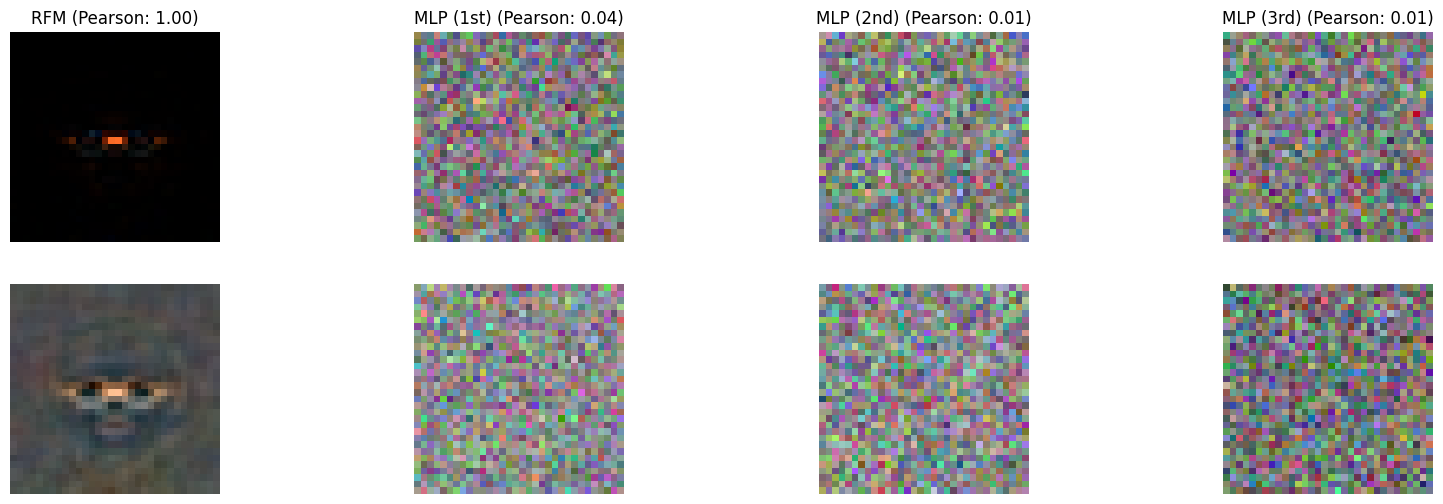

#### Dropout models (dropout@0.2)

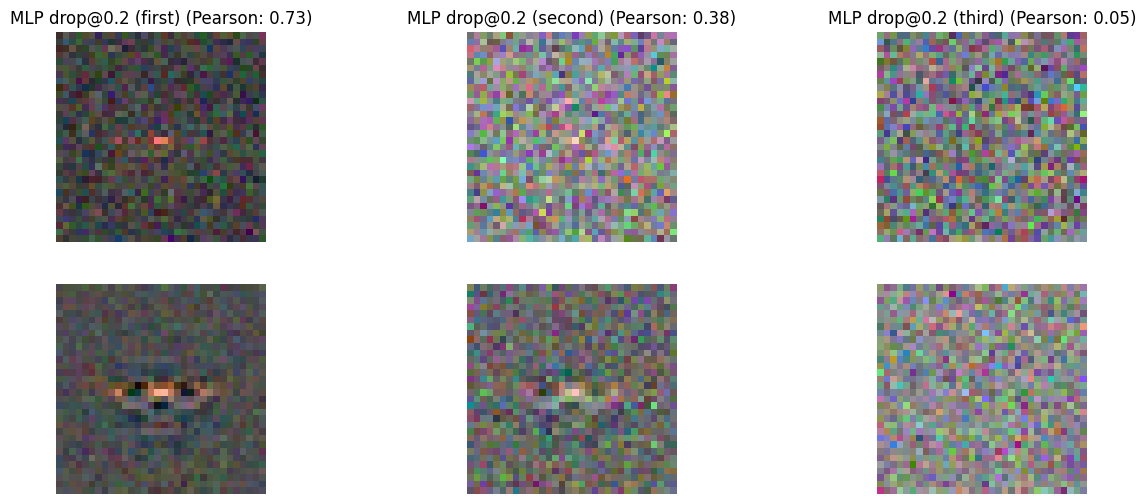

#### Dropout models (dropout@0.5)

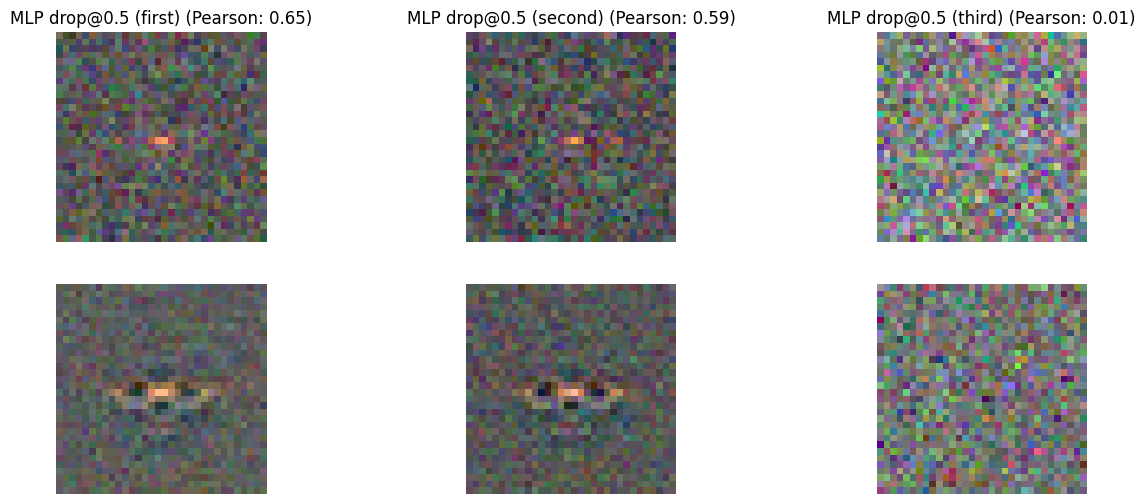

#### Dropout models (dropout@0.7)

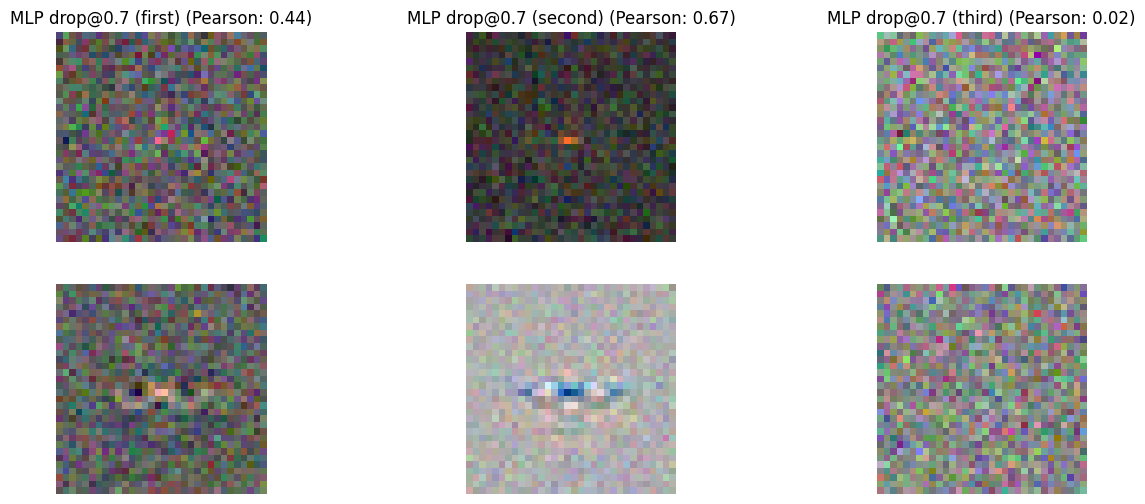

| Metric | MLP | MLP drop@0.2 | MLP drop@0.5 | MLP drop@0.7 |
| --- | --- | ---| ---| --- |
| Accuracy | 87.26% | 88.60%|88.05%|88.13% |
| MSE | 0.11 | 0.10|0.10|0.10 |


In [ ]:
from utils.visualize import visualize_M_dict, get_max_eigenvector


printmd(f"### Layer dropout (on CelebA)")

dim = next(iter(celeba_trainloader))[0].shape[1]
M_rfm, mse_rfm, acc_rfm, _ = rfm.train(celeba_trainloader, celeba_testloader, iters=3)
mlp, mse_mlp, acc_mlp, _ = nn.train(
    celeba_trainloader,
    celeba_valloader,
    celeba_testloader,
    num_epochs=1000,
    num_layers=5,
    lr=1e-2,
    width=dim,
)

M_size = torch.numel(M_rfm)
n_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)


mlp_drop = {}
mse_mlp_drop = {}
acc_mlp_drop = {}

for threshold in [0.2, 0.5, 0.7]:
    key = str(threshold)
    mlp_drop[key] = nn.MLP(
        dim,
        width=dim,
        num_layers=5,
        layer_dropout=threshold,
    )

    mlp_drop[key], mse_mlp_drop[key], acc_mlp_drop[key], _ = nn.train(
        celeba_trainloader,
        celeba_valloader,
        celeba_testloader,
        model=mlp_drop[key],
        num_epochs=1000,
        lr=1e-2,
    )

eig_rfm = get_max_eigenvector(M_rfm).flatten()
eig_mlp = get_max_eigenvector(mlp.M).flatten()
eig_mlp_2nd = get_max_eigenvector(mlp.M_second).flatten()
P_mlp = pearson(eig_rfm, eig_mlp)
P_mlp_2nd = pearson(eig_rfm, eig_mlp_2nd)


printmd(f"#### Baselines")
F_dict_base, _ = visualize_M_dict(
    {
        "RFM": (1, M_rfm),
        "MLP (1st)": (P_mlp, mlp.M),
        "MLP (2nd)": (P_mlp_2nd, mlp.M_second),
        "MLP (3rd)": (P_mlp_2nd, mlp.M_third),
    },
    target_plots=["eig"],
    is_pearson=True,
)
plt.show()

for threshold, mlp_th in mlp_drop.items():
    printmd(f"#### Dropout models (dropout@{threshold})")
    Ms = {}
    for layer in ["first", "second", "third"]:
        M_th = getattr(mlp_th, "M" if layer == "first" else f"M_{layer}")
        eig_mlp_drop = get_max_eigenvector(M_th).flatten()
        P_mlp_drop = pearson(eig_rfm, eig_mlp_drop)
        Ms[f"MLP drop@{threshold} ({layer})"] = (P_mlp_drop, M_th)

    F_dict_first, _ = visualize_M_dict(Ms, is_pearson=True)
    plt.show()


table = f"| Metric | MLP | MLP drop@{' | MLP drop@'.join(mlp_drop.keys())} |\n"
table += f"| --- | --- {'| ---' * len(mlp_drop.keys())} |\n"
table += f"| Accuracy | {acc_mlp:.2f}% | {'|'.join([f'{acc:.2f}%' for acc in acc_mlp_drop.values()])} |\n"
table += f"| MSE | {mse_mlp:.2f} | {'|'.join([f'{mse:.2f}' for mse in mse_mlp_drop.values()])} |\n"

printmd(table)

## 2. Gradientless optimization
This section investigates the effects of a few optimization methods that do not rely on gradients on the learned features. Even though gradientless methods are rarely used in neural networks, it could be an interesting results that the converged feature matrix still matches the one from the RFM (and the gradient-optimized MLP).

Methods used are Hessian-based optimization, PSO and SNES.

__Note__: This is outside of the claims of the paper, as the formal proofs assume first-order gradient-based optimization methods. If this experiment were to produce different results to the reproduction it does not mean that the original claims are wrong.

<a id='sec2'></a>

In [46]:
start = time.perf_counter_ns()
M_rfm, mse_rfm, acc_rfm, _ = rfm.train(celeba_trainloader, celeba_testloader, iters=3)
time_rfm = (time.perf_counter_ns() - start) / 1e9

start = time.perf_counter_ns()
mlp, mse_mlp, acc_mlp, _ = nn.train(
    celeba_trainloader,
    celeba_valloader,
    celeba_testloader,
    num_epochs=1000,
    lr=0.05,
    weight_decay=0.0,
    width=64,
)
time_mlp = (time.perf_counter_ns() - start) / 1e9

### Hessians

In [53]:
from torch_optimizer.adahessian import Adahessian

start = time.perf_counter_ns()
mlp_hess, mse_mlp_hess, acc_mlp_hess, _ = nn.train(
    celeba_trainloader,
    celeba_valloader,
    celeba_testloader,
    num_epochs=1000,
    lr=0.01,
    weight_decay=0.0,
    width=64,
    opt_fn=Adahessian,
)
time_mlp_hess = (time.perf_counter_ns() - start) / 1e9

### Particle Swarm Optimization (PSO)

In [49]:
from torch_pso import ParticleSwarmOptimizer

start = time.perf_counter_ns()
mlp_pso, mse_mlp_pso, acc_mlp_pso, _ = nn.train(
    celeba_trainloader,
    celeba_valloader,
    celeba_testloader,
    opt_fn=ParticleSwarmOptimizer,
    width=64,
    bias=False,
    num_epochs=100,
    opt_kwargs={
        "inertial_weight": 0.5,
        "num_particles": 200,
        "max_param_value": 0.05,
        "min_param_value": -0.05,
    },
)
time_mlp_pso = (time.perf_counter_ns() - start) / 1e9

### Separable Natural Evolution Strategies (SNES)

In [50]:
from evotorch.neuroevolution import SupervisedNE
from evotorch.algorithms import SNES

dim = next(iter(celeba_trainloader))[0].shape[1]

celeba_problem = SupervisedNE(
    celeba_trainset,
    nn.MLP,
    torch.nn.MSELoss(),
    network_args={"dim": dim, "width": 64, "num_layers": 4},
    minibatch_size=128,
    common_minibatch=True,
    num_actors=4,
    num_gpus_per_actor="max",
    device="cuda",
)

start = time.perf_counter_ns()
with suppress_stdout():
    searcher = SNES(celeba_problem, stdev_init=1, popsize=500, distributed=True)
    searcher.run(200)
    mlp_snes = celeba_problem.parameterize_net(searcher.status["center"]).cuda()
mse_mlp_snes, acc_mlp_snes = nn.val_step(mlp_snes, celeba_testloader)
time_mlp_snes = (time.perf_counter_ns() - start) / 1e9

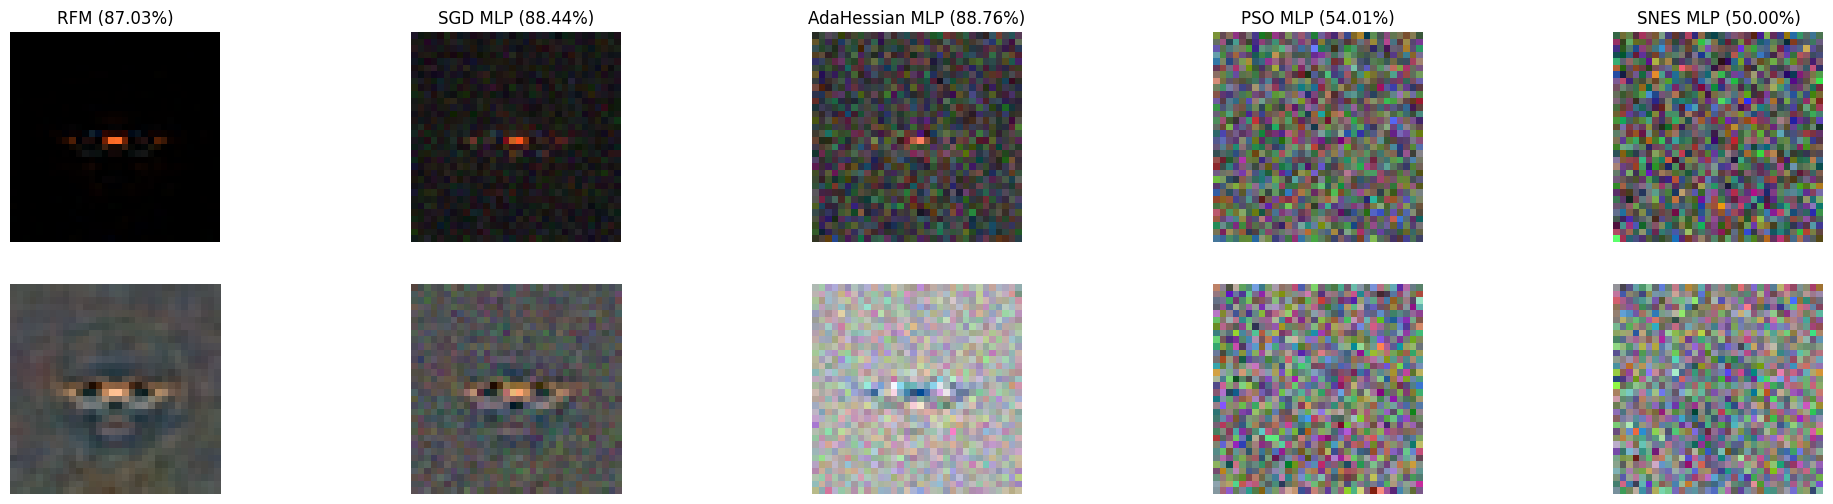

| Metric | RFM | SGD MLP | Hess MLP | ~~PSO MLP~~ | SNES MLP |
| --- | --- | --- |--- | --- | --- |
| Time | 178.50s | 122.65s | 396.92s | ~~53.12s~~ | 40.59s |
| Accuracy | 87.03% | 88.44% | 88.76% | ~~54.01%~~ | 50.00% |
| MSE | 0.10 | 0.09 | 0.10 | ~~0.49~~ | 0.50 |
| RPF pearson | 1.00 | 0.77 | 0.52 | ~~0.01~~ | 0.01 |


In [54]:
from utils.visualize import visualize_M_dict, get_max_eigenvector

acc_rfm = acc_rfm if "acc_rfm" in locals() else 0
acc_mlp = acc_mlp if "acc_mlp" in locals() else 0
acc_mlp_hess = acc_mlp_hess if "acc_mlp_hess" in locals() else 0
acc_mlp_pso = acc_mlp_pso if "acc_mlp_pso" in locals() else 0
acc_mlp_snes = acc_mlp_snes if "acc_mlp_snes" in locals() else 0
mse_rfm = mse_rfm if "mse_rfm" in locals() else 0
mse_mlp = mse_mlp if "mse_mlp" in locals() else 0
mse_mlp_hess = mse_mlp_hess if "mse_mlp_hess" in locals() else 0
mse_mlp_pso = mse_mlp_pso if "mse_mlp_pso" in locals() else 0
mse_mlp_snes = mse_mlp_snes if "mse_mlp_snes" in locals() else 0
time_rfm = time_rfm if "time_rfm" in locals() else 0
time_mlp = time_mlp if "time_mlp" in locals() else 0
time_mlp_hess = time_mlp_hess if "time_mlp_hess" in locals() else 0
time_mlp_pso = time_mlp_pso if "time_mlp_pso" in locals() else 0
time_mlp_snes = time_mlp_snes if "time_mlp_snes" in locals() else 0

P = {}
Ms = {}
if "M_rfm" in locals():
    P["RFM"] = 1.0
    Ms["RFM"] = (P["RFM"], M_rfm / np.linalg.norm(M_rfm))
    eig_rfm = get_max_eigenvector(M_rfm).flatten()
if "mlp" in locals():
    eig_mlp = get_max_eigenvector(mlp.M).flatten()
    P["SGD MLP"] = pearson(eig_rfm, eig_mlp)
    Ms["SGD MLP"] = (P["SGD MLP"], mlp.M / np.linalg.norm(mlp.M))
if "mlp_hess" in locals():
    eig_mlp_hess = get_max_eigenvector(mlp_hess.M).flatten()
    P["AdaHessian MLP"] = pearson(eig_rfm, eig_mlp_hess)
    Ms["AdaHessian MLP"] = (
        P["AdaHessian MLP"],
        mlp_hess.M / np.linalg.norm(mlp_hess.M),
    )
if "mlp_pso" in locals():
    eig_mlp_pso = get_max_eigenvector(mlp_pso.M).flatten()
    P["PSO MLP"] = pearson(eig_rfm, eig_mlp_pso)
    Ms["PSO MLP"] = (P["PSO MLP"], mlp_pso.M / np.linalg.norm(mlp_pso.M))
if "mlp_snes" in locals():
    eig_mlp_snes = get_max_eigenvector(mlp_snes.M).flatten()
    P["SNES MLP"] = pearson(eig_rfm, eig_mlp_snes)
    Ms["SNES MLP"] = (P["SNES MLP"], mlp_snes.M / np.linalg.norm(mlp_snes.M))

visualize_M_dict(Ms, is_pearson=True)
plt.show()

table = f"| Metric | RFM | SGD MLP | Hess MLP | PSO MLP | SNES MLP |\n| --- | --- | --- |--- | --- | --- |\n"
table += f"| Time | {time_rfm:.2f}s | {time_mlp:.2f}s | {time_mlp_hess:.2f}s | {time_mlp_pso:.2f}s | {time_mlp_snes:.2f}s |\n"
table += f"| Accuracy | {acc_rfm:.2f}% | {acc_mlp:.2f}% | {acc_mlp_hess:.2f}% | {acc_mlp_pso:.2f}% | {acc_mlp_snes:.2f}% |\n"
table += f"| MSE | {mse_rfm:.2f} | {mse_mlp:.2f} | {mse_mlp_hess:.2f} | {mse_mlp_pso:.2f} | {mse_mlp_snes:.2f} |\n"
table += f"| RFM pearson | {P['RFM']:.2f} | {P['SGD MLP']:.2f} | {P['AdaHessian MLP']:.2f} | {P['PSO MLP']:.2f} | {P['SNES MLP']:.2f} |\n"

printmd(table)

## 3. RFM improvements
RFMs have been shown to work well in a variety of cases and to be an useful tool when investigating feature learning in neural networks. However, there are some limitations to the current implementation of RFMs. In this section, we will discuss some of these limitations and possible improvements, namely:
- They don't scale well to large datasets, or even large samples. The __main reason for poor scaling is the feature matrix gradient computation__, which is also very slow. Additionally, another cause is the linear solver needed by the kernel machine. This is discussed in the subsections ["Evaluation of linear solve alternatives"](#sec32) and ["Feature hypernetwork"](#sec33).
- The feature matrix is just a matrix, which is manually updated with the gradient outer product. Results from the _matrix swap subsection_ in [__section 1__](#sec1) suggest that RFM training could potentially become faster and more stable with an hypernetwork that generates the feature matrix.

This third section touches on 3 (performance related) aspects of RFMs:
1. Scaling to large datasets, section [__3.1 Scaling experiment__](#sec31)
2. Changes to the linear solver, section [__3.2 Evaluation of linear solve alternatives__](#sec32)
3. Changes to the feature matrix gradient computation, in particular __hypernetworks__, section [__3.3 Feature hypernetwork__](#sec33)

<a id='sec3'></a>

### Scaling experiment
This section focuses on the time saline of RFMs against MLPs and regular kernel machines. ["On Feature Scaline of Recursive Feature Machines"](https://arxiv.org/pdf/2303.15745.pdf) already experimented with performance scaling (in terms of MSE) at varying feature matrix size, but does not present any results on runtime which has been shown already to be an issue with RFMs in the [reproducibility notebook](reproduction.ipynb).

<a id='sec31'></a>

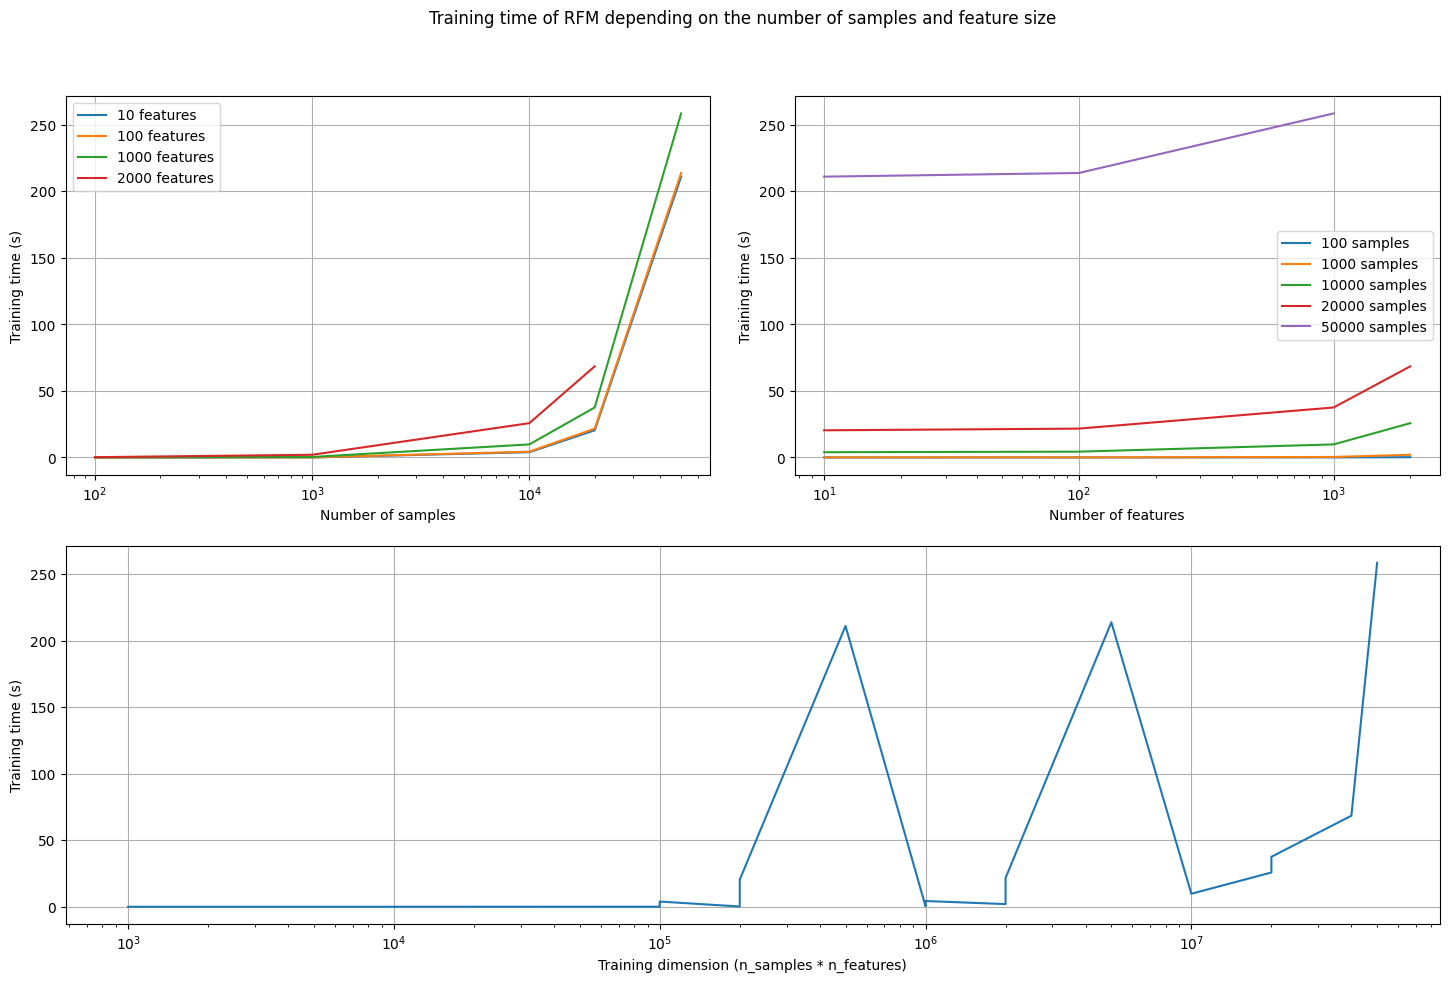

In [ ]:
N_SAMPLES = [100, 1000, 10000, 20000, 50000]
N_FEATURES = [10, 100, 1000, 2000]

rfm_times = {}

for s in N_SAMPLES:
    for n in N_FEATURES:
        train_dataset = (np.random.rand(s, n), np.random.rand(s, 1))
        test_dataset = (np.random.rand(1, n), np.random.rand(1, 1))

        start = time.perf_counter_ns()
        rfm.train(train_dataset, test_dataset, iters=1)
        # timeout at 5 minutes
        if (time.perf_counter_ns() - start) / 1e9 > 300.0:
            break
        rfm_times[(s, n)] = (time.perf_counter_ns() - start) / 1e9

fig, ax = plt.subplot_mosaic("AB;CC", figsize=(15, 10))

fig.suptitle("Training time of RFM depending on the number of samples and feature size")
fig.tight_layout(pad=3.0)

for n in N_FEATURES:
    ax["A"].plot(
        [s for s in N_SAMPLES if (s, n) in rfm_times],
        [rfm_times[(s, n)] for s in N_SAMPLES if (s, n) in rfm_times],
        label=f"{n} features",
    )
ax["A"].set_xlabel("Number of samples")
ax["A"].set_ylabel("Training time (s)")
ax["A"].legend()
ax["A"].set_xscale("log")
ax["A"].grid()


for s in N_SAMPLES:
    ax["B"].plot(
        [n for n in N_FEATURES if (s, n) in rfm_times],
        [rfm_times[(s, n)] for n in N_FEATURES if (s, n) in rfm_times],
        label=f"{s} samples",
    )
ax["B"].set_xlabel("Number of features")
ax["B"].set_ylabel("Training time (s)")
ax["B"].legend()
ax["B"].set_xscale("log")
ax["B"].grid()

vals = [
    rfm_times[(s, n)] for s, n in sorted(rfm_times.keys(), key=lambda x: x[0] * x[1])
]
ax["C"].plot(sorted([s * n for s, n in rfm_times.keys()]), vals)
ax["C"].set_xlabel("Training dimension (n_samples * n_features)")
ax["C"].set_ylabel("Training time (s)")
ax["C"].set_xscale("log")
ax["C"].grid()

plt.show()

### Evaluation of linear solve alternatives
This section compares the speed of different linear solvers for the kernel machine. The solvers are:
- `torch.linalg.solve`: the current solver used in the RFM implementation.
- `jax.linalg.solve`: jax implementation of `solve`.
- `torch.linalg.lu_solve`: akin to the current solver used in the RFM implementation.
- `torch.linalg.lstsq`: least squares solver, which is sometimes slower than `solve`.
- Gradient descent: a simple iterative gradient descent solver, which is not guaranteed to converge to the solution and is slower than `torch.linalg.solve`.

-> Conclusion: `torch.linalg.solve` is not so bad after all, it's in general not the main bottleneck of the RFM implementation.

<a id='sec32'></a>

Text(0.5, 0, 'N')

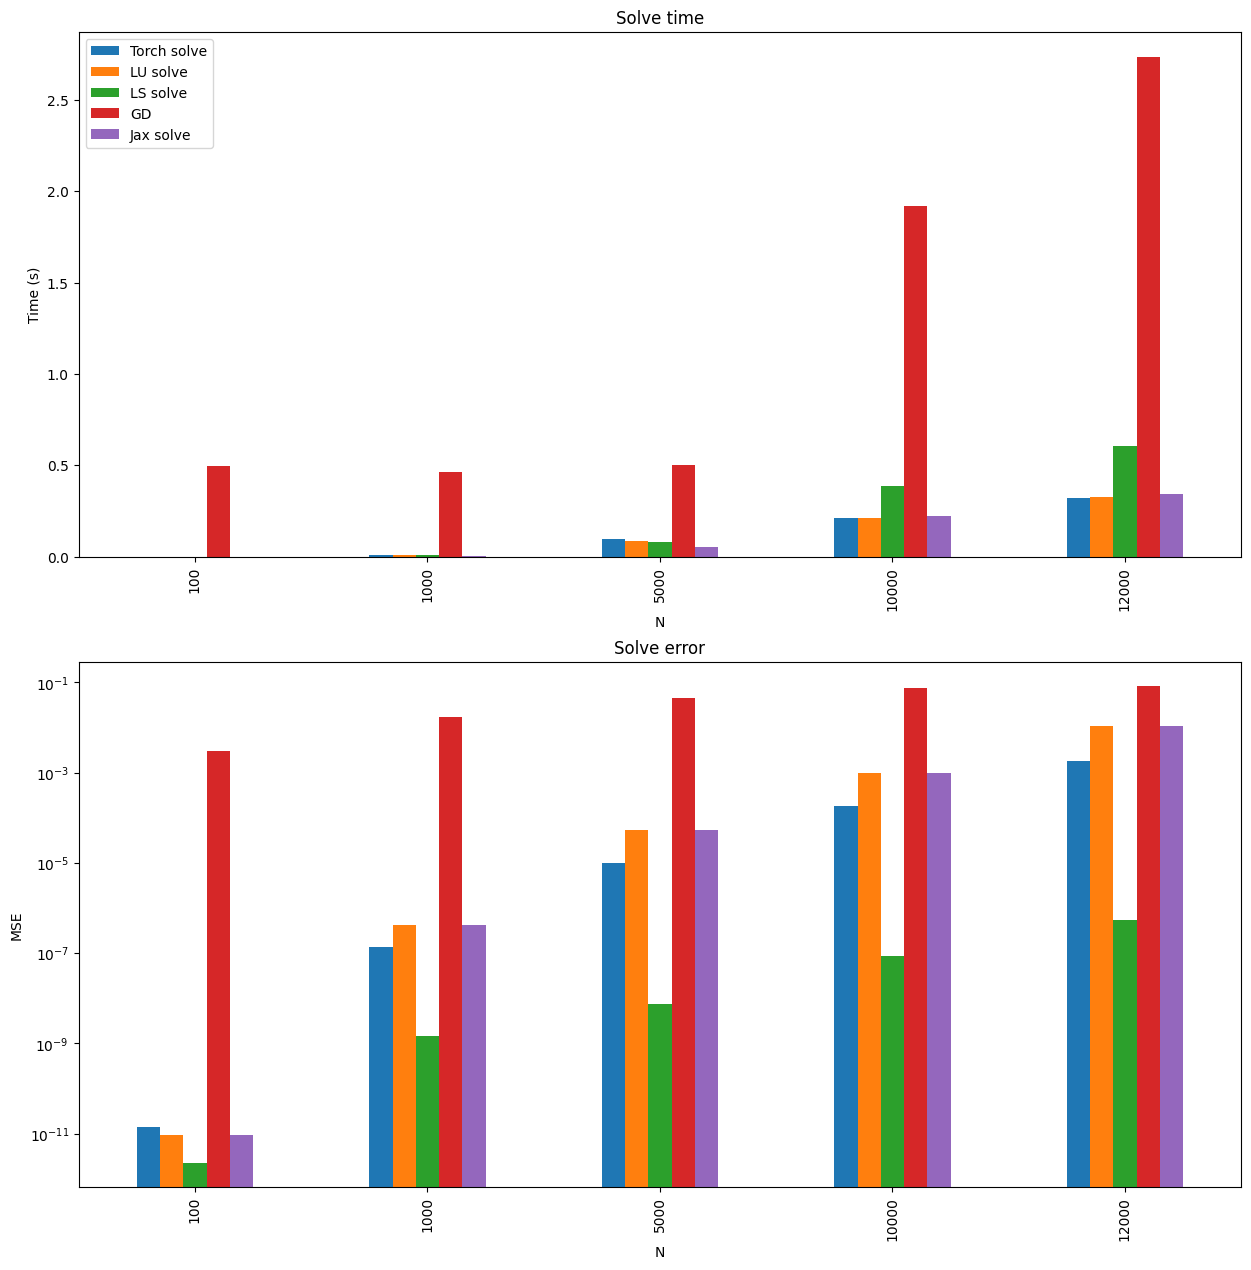

In [ ]:
import torch.linalg

import jax
import jax.numpy as jnp

import pandas as pd

result_solve_times = []
result_solve_errors = []

INTERVALS = [100, 1000, 5000, 10000, 12000]

for N in INTERVALS:
    solve_times = {}
    solve_errors = {}

    a = torch.randn(N, N).cuda()
    b = torch.randn(N, 1).cuda()

    # solve full matrix
    st = time.perf_counter_ns()
    x_base = torch.linalg.solve(a, b)
    solve_times["Torch solve"] = (time.perf_counter_ns() - st) / 1e9
    solve_errors["Torch solve"] = torch.nn.functional.mse_loss(a @ x_base, b).item()
    del x_base

    # LU solve
    st = time.perf_counter_ns()
    LU, pivots = torch.linalg.lu_factor(a)
    x_lu = torch.linalg.lu_solve(LU, pivots, b)
    solve_times["LU solve"] = (time.perf_counter_ns() - st) / 1e9
    solve_errors["LU solve"] = torch.nn.functional.mse_loss(a @ x_lu, b).item()
    del LU, pivots, x_lu

    # LS optimization
    st = time.perf_counter_ns()
    x_ls = torch.linalg.lstsq(a, b).solution
    solve_times["LS solve"] = (time.perf_counter_ns() - st) / 1e9
    solve_errors["LS solve"] = torch.nn.functional.mse_loss(a @ x_ls, b).item()
    del x_ls

    # GD optimization
    st = time.perf_counter_ns()
    x_gd = torch.randn((N, 1), requires_grad=True).cuda()
    x_gd = torch.nn.Parameter(x_gd)
    opt = torch.optim.Adam([x_gd], lr=0.1)
    loss = 1
    for _ in range(1000):
        opt.zero_grad()
        loss = torch.nn.functional.mse_loss(a @ x_gd, b)
        loss.backward()
        opt.step()
    x_gd = x_gd.detach()
    solve_times["GD"] = (time.perf_counter_ns() - st) / 1e9
    solve_errors["GD"] = torch.nn.functional.mse_loss(a @ x_gd, b).item()
    del x_gd

    # # LBFGS optimization
    # st = time.perf_counter_ns()
    # x_lbfgs = torch.randn((N, 1), requires_grad=True).cuda()
    # x_lbfgs = torch.nn.Parameter(x_lbfgs)
    # opt = torch.optim.LBFGS([x_lbfgs], lr=0.1, line_search_fn="strong_wolfe")
    # loss = 1
    # while loss > 1e-3:
    #     def closure():
    #         opt.zero_grad()
    #         loss = torch.nn.functional.mse_loss(a @ x_lbfgs, b)
    #         loss.backward()
    #         return loss
    #     opt.step(closure)
    # x_lbfgs = x_lbfgs.detach()
    # solve_times["LBFGS"] = (time.perf_counter_ns() - st) / 1e9
    # solve_errors["LBFGS"] = torch.nn.functional.mse_loss(a @ x_lbfgs, b).item()

    # jax solve
    a_jax = jnp.array(a.cpu().numpy())
    b_jax = jnp.array(b.cpu().numpy())

    @jax.jit
    def solve_jax(a, b):
        return jnp.linalg.solve(a, b)

    solve_jax(a_jax, b_jax)

    st = time.perf_counter_ns()
    x_jax = solve_jax(a_jax, b_jax)
    solve_times["Jax solve"] = (time.perf_counter_ns() - st) / 1e9
    x_jax = torch.from_numpy(np.asarray(x_jax)).cuda()
    solve_errors["Jax solve"] = torch.nn.functional.mse_loss(a @ x_jax, b).item()
    del a_jax, b_jax, x_jax

    del a, b

    result_solve_times.append(solve_times)
    result_solve_errors.append(solve_errors)

# two seaborn subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
# plot solve times
df = pd.DataFrame(result_solve_times, index=INTERVALS)
df.plot.bar(ax=ax1)
ax1.set_title("Solve time")
ax1.set_ylabel("Time (s)")
ax1.set_xlabel("N")
# plot solve errors
df = pd.DataFrame(result_solve_errors, index=INTERVALS)
df.plot.bar(ax=ax2)
ax2.get_legend().remove()
ax2.set_yscale("log")
ax2.set_title("Solve error")
ax2.set_ylabel("MSE")
ax2.set_xlabel("N")

### Feature hypernetwork
Finally, this subsection shows the effect of a feature hypernetwork, which is a network that generates the feature matrix at every iteration and is updated with Adam.

- __Before:__ RFM learnable parameters are the feature matrix itself, which is updated with the gradient outer product.
- __Now:__ RFM learnable parameters are the feature hypernetwork, which is updated with Adam.

<a id='sec33'></a>

#### Feature matrix analysis
This section shows the effect of the feature hypernetwork on the feature matrix __ through training__. Ideally, RFMs and RFMLPs should have similar matrices through training, even though the gradients are computed and applied very differently.

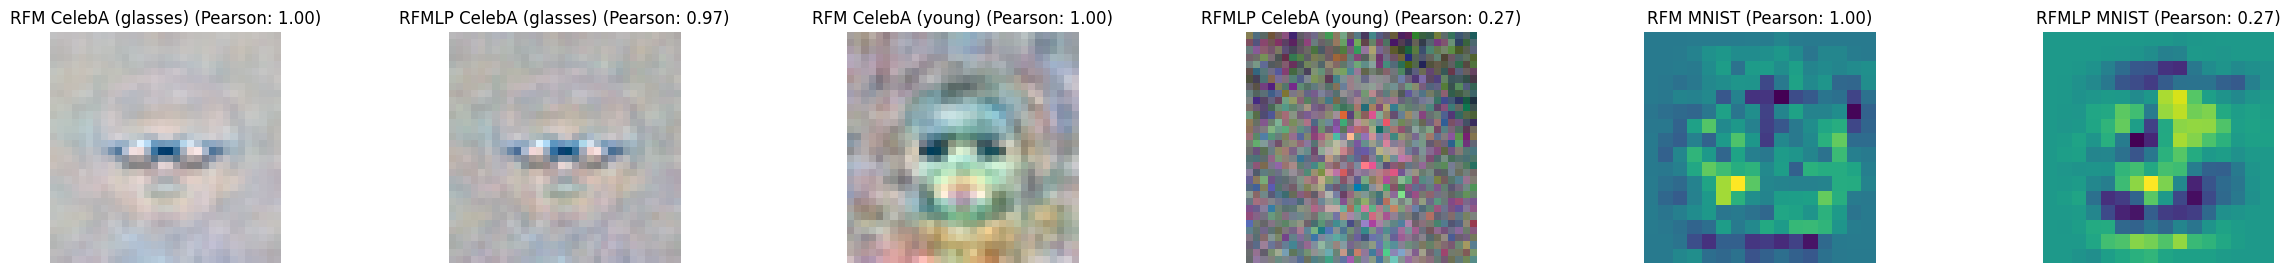

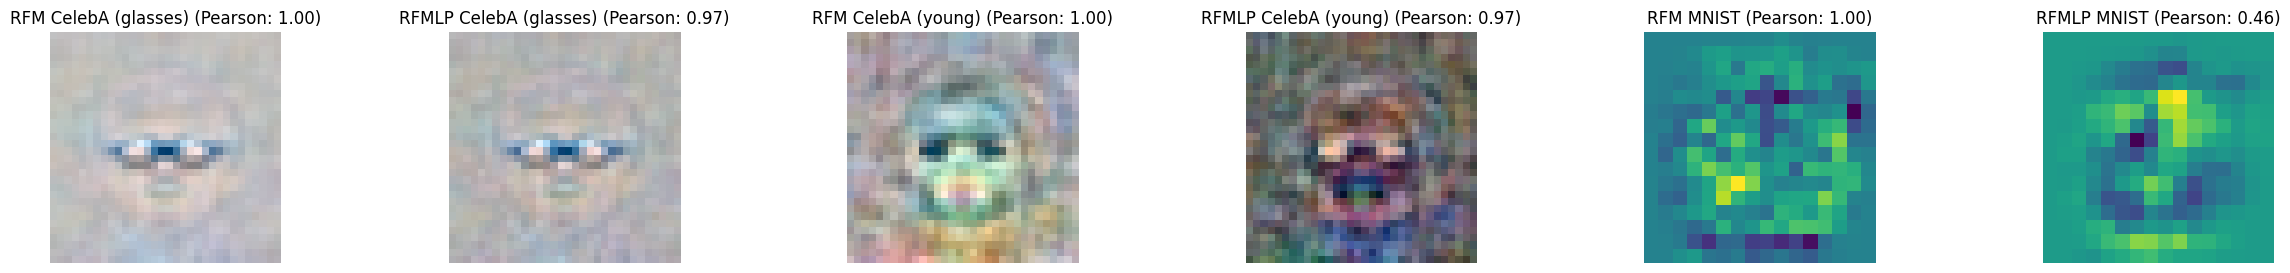

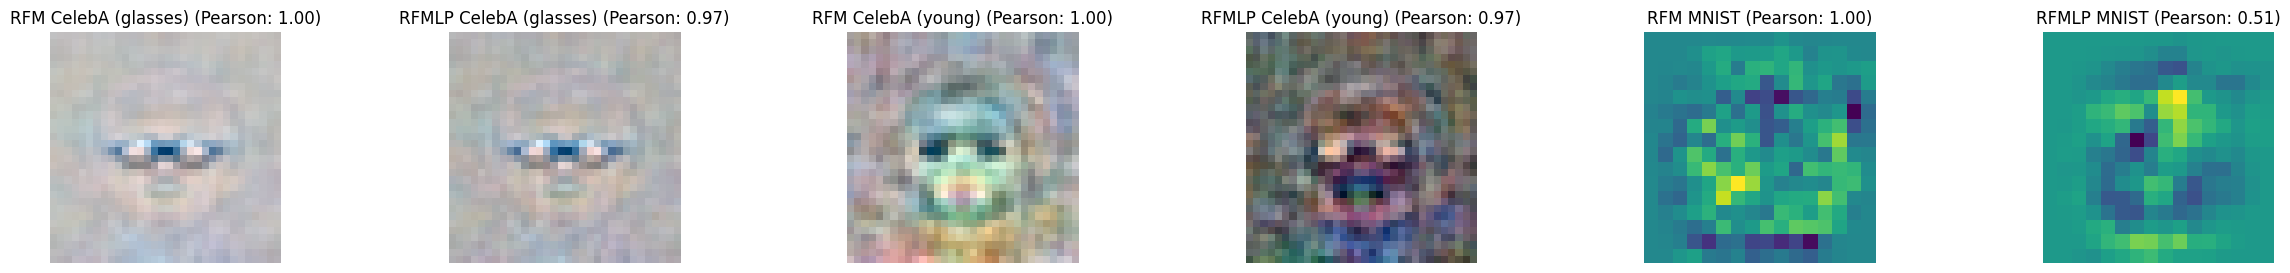

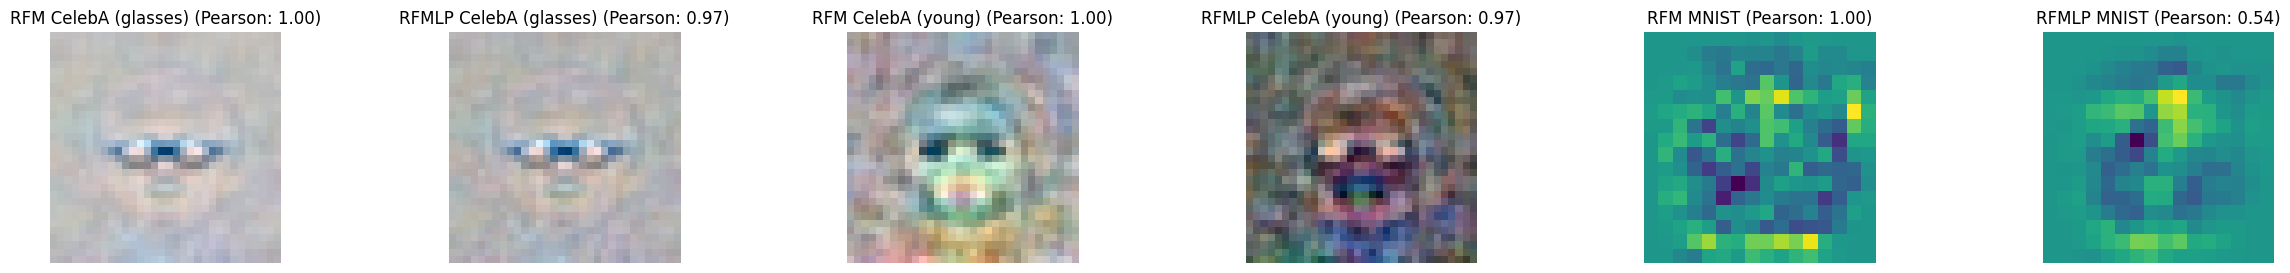

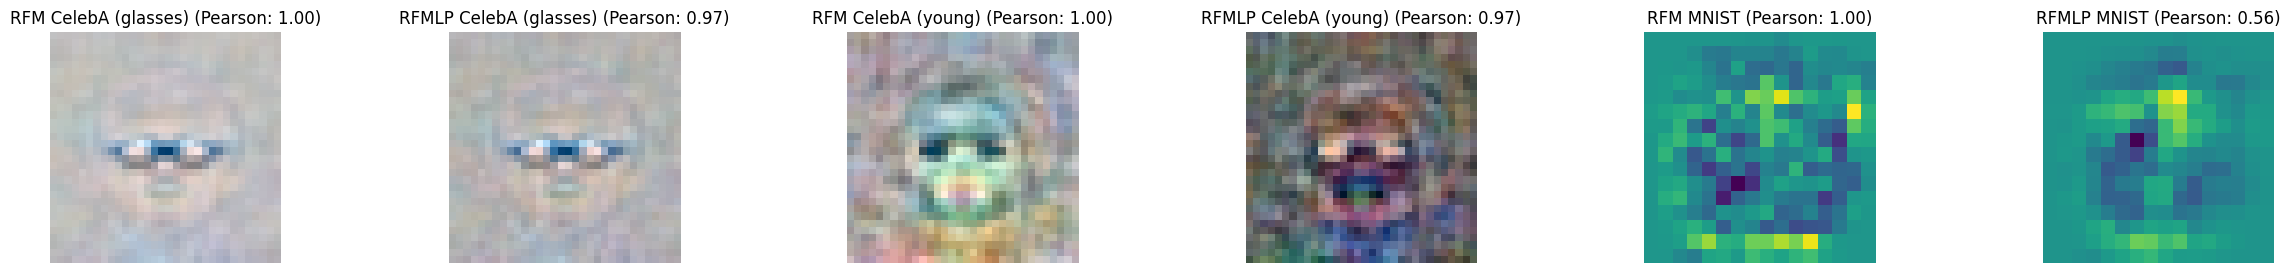

In [55]:
import torch

from utils.visualize import visualize_M_dict, get_max_eigenvector

d = next(iter(celeba_trainloader))[0].shape[1]
M_rfm_celeba = torch.eye(d)
rfmlp_celeba = rfm.RFMLP(d, 10, 1e-3)
M_rfm_celeba2 = torch.eye(d)
rfmlp_celeba2 = rfm.RFMLP(d, 10, 1e-3)


d = next(iter(mnist_trainloader))[0].shape[1]
M_rfm_mnist = torch.eye(d)
rfmlp_mnist = rfm.RFMLP(d, 10, 1e-3)

for i in range(5):
    M_rfm_celeba, _, _, _ = rfm.train(
        celeba_trainloader, celeba_testloader, M=M_rfm_celeba, iters=1, soft_gamma=1e-5
    )
    rfmlp_celeba, _, _, _ = rfm.train_hypernet(
        celeba_trainloader, celeba_testloader, model=rfmlp_celeba, iters=1, lr=1e-4
    )
    M_rfm_celeba2, _, _, _ = rfm.train(
        celeba_young_trainloader,
        celeba_young_testloader,
        M=M_rfm_celeba2,
        iters=1,
        soft_gamma=1e-5,
    )
    rfmlp_celeba2, _, _, _ = rfm.train_hypernet(
        celeba_young_trainloader,
        celeba_young_testloader,
        model=rfmlp_celeba2,
        iters=1,
        lr=1e-4,
    )

    M_rfm_mnist, _, _, _ = rfm.train(
        mnist_trainloader, mnist_testloader, M=M_rfm_mnist, iters=1
    )
    rfmlp_mnist, _, _, _ = rfm.train_hypernet(
        mnist_trainloader, mnist_testloader, model=rfmlp_mnist, iters=1
    )

    M_rfm_celeba_ = M_rfm_celeba.detach().cpu().numpy()
    rfmlp_M_celeba = rfmlp_celeba.M.detach().cpu().numpy()
    M_rfm_celeba2_ = M_rfm_celeba2.detach().cpu().numpy()
    rfmlp_M_celeba2 = rfmlp_celeba2.M.detach().cpu().numpy()

    M_rfm_mnist_ = M_rfm_mnist.detach().cpu().numpy()
    rfmlp_M_mnist = rfmlp_mnist.M.detach().cpu().numpy()

    P_celeba = pearson(M_rfm_celeba_, rfmlp_M_celeba, eig=True)
    P_celeba2 = pearson(M_rfm_celeba2_, rfmlp_M_celeba2, eig=True)
    P_mnist = pearson(M_rfm_mnist_, rfmlp_M_mnist, eig=True)

    visualize_M_dict(
        {
            "RFM CelebA (glasses)": (1, M_rfm_celeba_),
            "RFMLP CelebA (glasses)": (P_celeba, rfmlp_M_celeba),
            "RFM CelebA (young)": (1, M_rfm_celeba2_),
            "RFMLP CelebA (young)": (P_celeba2, rfmlp_M_celeba2),
            "RFM MNIST": (1, M_rfm_mnist_),
            "RFMLP MNIST": (P_mnist, rfmlp_M_mnist),
        },
        target_plots=["eig"],
        # title=f"RFM vs RFMLP (iter {i + 1})",
        is_pearson=True,
    )
    plt.show()

#### Performance comparison

In [ ]:
from utils.data import get_tabular_datasets

N_SAMPLES_TABULAR = 5000

TABULAR_DATASETS = [
    "electricity",
    "telescope",
    "higgs",
    "covertype",
]

table_dataset_dict = get_tabular_datasets(
    TABULAR_DATASETS, max_samples=N_SAMPLES_TABULAR
)

datasets = {
    **table_dataset_dict,
    **{"MNIST": mnist_dataset, "CelebA": celeba_dataset},
}

result_dict = {}
time_dict = {}

In [ ]:
from methods import xgb

for name, data in datasets.items():
    if name in result_dict:
        continue

    train_data, evaluation_data = split(data, p=0.8)
    val_data, test_data = split(evaluation_data, p=0.1)

    display(
        Markdown(
            f"Training on '__{name}__'\n"
            f"Train size: {len(train_data)}, "
            f"eval size: {len(val_data)} + {len(test_data)}"
        )
    )

    train_i = torch.utils.data.DataLoader(
        train_data, batch_size=1024, shuffle=True, num_workers=2
    )
    val_i = torch.utils.data.DataLoader(
        val_data, batch_size=100, shuffle=False, num_workers=1
    )
    test_i = torch.utils.data.DataLoader(
        test_data, batch_size=512, shuffle=False, num_workers=1
    )

    with suppress_stdout():
        st = time.perf_counter_ns()
        _, _, acc_rfm, _ = rfm.train(train_i, test_i, iters=5)
        time_rfm = (time.perf_counter_ns() - st) / 1e9
        st = time.perf_counter_ns()
        _, _, acc_rfmlp, _ = rfm.train_hypernet(train_i, test_i, iters=5)
        time_rfmlp = (time.perf_counter_ns() - st) / 1e9
        st = time.perf_counter_ns()
        _, _, acc_mlp, _ = nn.train(train_i, val_i, train_i, lr=1e-2, num_layers=4)
        time_mlp = (time.perf_counter_ns() - st) / 1e9
        # xgboost
        try:
            st = time.perf_counter_ns()
            _, acc_xgb = xgb.train(train_data, test_data)
            time_xgb = (time.perf_counter_ns() - st) / 1e9
        except:
            acc_xgb = 0.0
            time_xgb = 0.0

    result_dict[name] = {
        "RFM": acc_rfm,
        "MLP": acc_mlp,
        "XGB": acc_xgb,
        "RFMLP": acc_rfmlp,
    }
    time_dict[name] = {
        "RFM": time_rfm,
        "MLP": time_mlp,
        "XGB": time_xgb,
        "RFMLP": time_rfmlp,
    }

result_table = (
    f"| Dataset | RFM | RFMLP | MLP | XGB |\n| --- | --- | --- | --- | --- |\n"
)
for name, results in result_dict.items():
    result_table += (
        f"| {name} | "
        f"{results['RFM']:.2f}% |"
        f"{results['RFMLP']:.2f}% |"
        f"{results['MLP']:.2f}% |"
        f"{results['XGB']:.2f}% |\n"
    )

printmd(result_table)

time_table = f"| Dataset | RFM | RFMLP | MLP | XGB |\n| --- | --- | --- | --- | --- |\n"
for name, results in time_dict.items():
    time_table += (
        f"| {name} | "
        f"{results['RFM']:.2f}s |"
        f"{results['RFMLP']:.2f}s |"
        f"{results['MLP']:.2f}s |"
        f"{results['XGB']:.2f}s |\n"
    )
printmd(time_table)

printmd("---")

Training on '__electricity__'
Train size: 4000, eval size: 100 + 900

Training on '__telescope__'
Train size: 4000, eval size: 100 + 900

Training on '__higgs__'
Train size: 4000, eval size: 100 + 900

Training on '__covertype__'
Train size: 4000, eval size: 100 + 900

Training on '__MNIST__'
Train size: 4800, eval size: 120 + 1080

Training on '__CelebA__'
Train size: 5200, eval size: 130 + 1170

| Dataset | RFM | RFMLP | MLP | XGB |
| --- | --- | --- | --- | --- |
| electricity | 95.78% |94.89% |88.15% |98.33% |
| telescope | 100.00% |100.00% |49.98% |100.00% |
| higgs | 67.78% |64.33% |61.12% |68.22% |
| covertype | 80.78% |77.78% |73.88% |77.44% |
| MNIST | 98.52% |98.52% |91.69% |97.96% |
| CelebA | 87.01% |87.95% |86.10% |89.91% |


| Dataset | RFM | RFMLP | MLP | XGB |
| --- | --- | --- | --- | --- |
| electricity | 3.01s |2.91s |138.42s |0.26s |
| telescope | 9.74s |14.45s |86.12s |0.10s |
| higgs | 3.57s |2.82s |130.80s |0.72s |
| covertype | 3.00s |2.79s |105.86s |0.36s |
| MNIST | 6.69s |5.19s |143.56s |1.41s |
| CelebA | 283.73s |21.55s |113.22s |21.12s |


---

## 4. Structural constraints
The last section focuses on the feature matrix of constrained networks (e.g. CNNs, which are constrained by the convolution operation). Namely, in normal MLP all inputs are connected and the features are learned independently, while in CNNs inputs are connected only locally and the features are learned in a way that is equivariant to translation.

The main question is: __how does the feature matrix of a constrained network (CNN) compare to the one of an RFM, and as a consequence to an MLP?__

The main challenge here is getting the feature matrix, especially from CNNs. Two approaches are investigated:
- Sample-based: average the  first layer output over a large number of samples. This is misleading: the actual comparison are done between the first eigenvector of the RFM and the whole CNN "feature matrix". The actual feature matrices have very different shapes, $(c \cdot D^2) \times (c \cdot D^2)$ for the RFM (e.g. $(3 \cdot 32^2) \times (3 \cdot 32^2)$) and $D \times D$ for the CNN (e.g. $3 \times 32 \times 32$).
- Without CNNs: equivariant MLPs.

<a id='sec4'></a>

### CNN, based on samples

In [3]:
models = {}

In [42]:
cnn = nn.CNN(d=128, c=3)
cnn, cnn_mse, cnn_acc, _ = nn.train(
    celeba_trainloader,
    celeba_valloader,
    celeba_testloader,
    model=cnn,
    num_epochs=200,
    opt_fn=torch.optim.Adam,
    lr=1e-2,
)
M_rfm, rfm_mse, rfm_acc, _ = rfm.train(celeba_trainloader, celeba_testloader, iters=3)
models["CelebA"] = {"RFM": (M_rfm, rfm_acc), "CNN": (cnn, cnn_acc)}

In [ ]:
cnn = nn.CNN(d=32, c=1, pool_size=(2, 1))
cnn, cnn_mse, cnn_acc, _ = nn.train(
    mnist_trainloader,
    mnist_valloader,
    mnist_testloader,
    model=cnn,
    num_epochs=50,
    opt_fn=torch.optim.Adam,
    lr=5e-3,
)
M_rfm, rfm_mse, rfm_acc, _ = rfm.train(mnist_trainloader, mnist_testloader, iters=3)
models["MNIST"] = {"RFM": (M_rfm, rfm_acc), "CNN": (cnn, cnn_acc)}

#### CelebA

RFM acc: 86.24% - CNN acc: 85.22% and params 15424

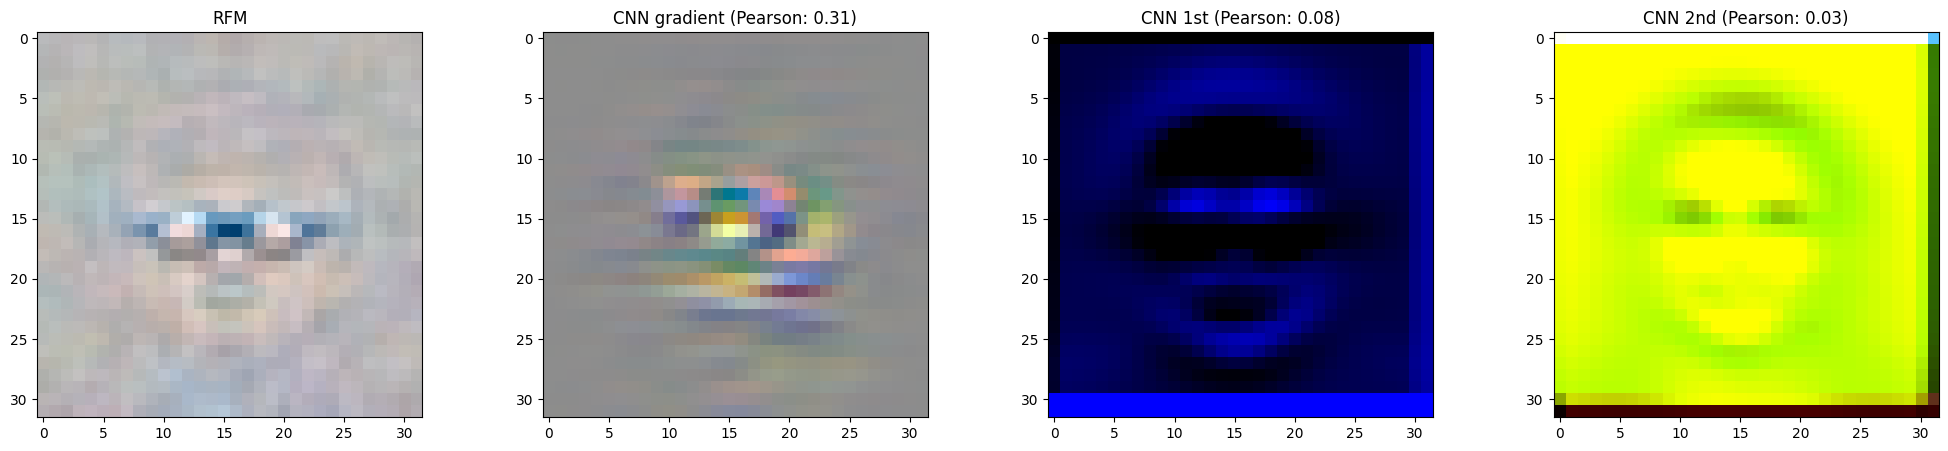

#### MNIST

RFM acc: 98.09% - CNN acc: 93.61% and params 8876

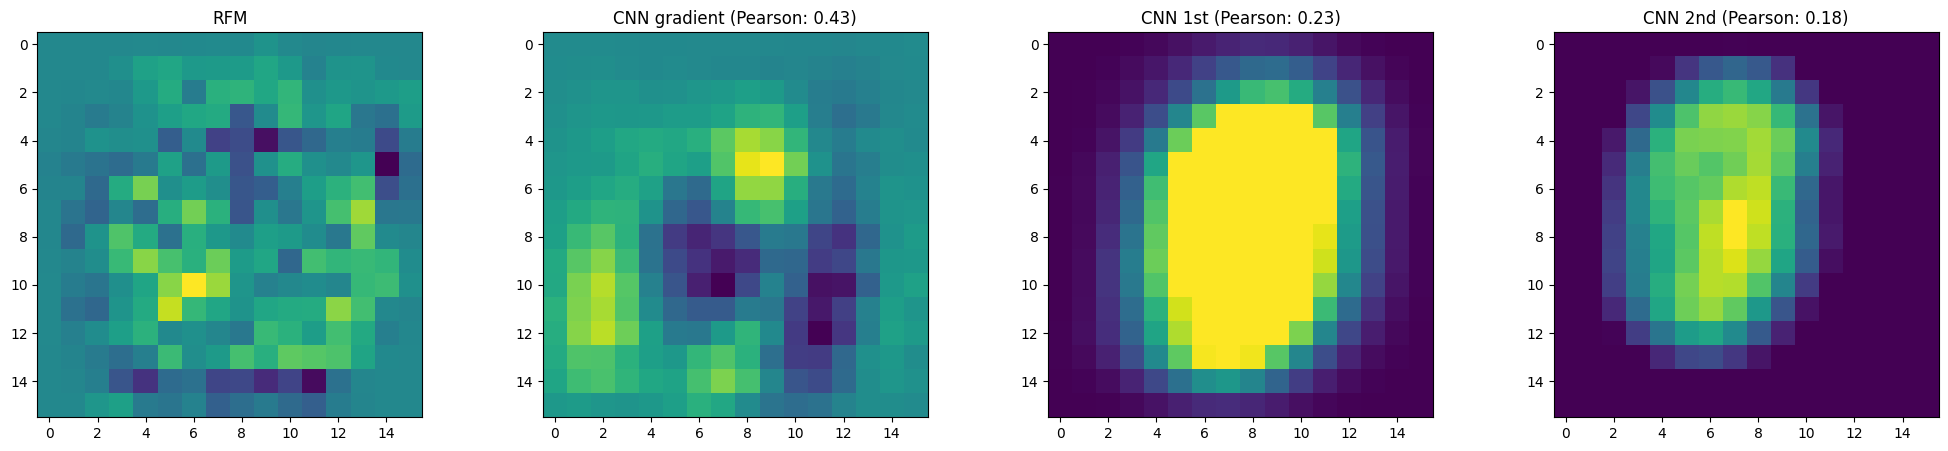

In [43]:
import matplotlib.pyplot as plt

from utils.visualize import get_max_eigenvector
from utils.misc import unsqueeze_shape

for dataset, models_dict in models.items():
    printmd(f"#### {dataset}")
    cnn, cnn_acc = models_dict["CNN"]
    M_rfm, rfm_acc = models_dict["RFM"]

    printmd(
        f"RFM acc: {rfm_acc:.2f}% - "
        f"CNN acc: {cnn_acc:.2f}% and params {sum(p.numel() for p in cnn.parameters())}"
    )

    test_data = torch.cat(
        [x for dl in DATALOADERS[dataset.lower()] for x, _ in dl], dim=0
    )
    test_labels = torch.cat(
        [y for dl in DATALOADERS[dataset.lower()] for _, y in dl], dim=0
    )

    x = test_data.view(test_data.shape[0], *unsqueeze_shape(test_data.shape[1]))
    M_cnn = cnn.conv1(x).mean(0).clip(0.0, 1.0)
    M_cnn = M_cnn.permute(1, 2, 0).detach().cpu().numpy()
    M_cnn2 = cnn.conv2(x).mean(0).clip(0.0, 1.0)
    M_cnn2 = M_cnn2.permute(1, 2, 0).detach().cpu().numpy()

    # M_cnn_grad is the gradient to the input
    x.requires_grad = True
    loss = torch.mean((cnn(x) - test_labels) ** 2)
    loss.backward()
    M_cnn_grad = x.grad.mean(0)
    M_cnn_grad = (M_cnn_grad - M_cnn_grad.min()) / (M_cnn_grad.max() - M_cnn_grad.min())
    M_cnn_grad = M_cnn_grad.clip(0.0, 1.0).permute(1, 2, 0).detach().cpu().numpy()

    eig_rfm = get_max_eigenvector(M_rfm)

    with suppress_stdout():
        P = pearson(eig_rfm.flatten(), M_cnn.flatten())
        P2 = pearson(eig_rfm.flatten(), M_cnn2.flatten())
        Pgrad = pearson(eig_rfm.flatten(), M_cnn_grad.flatten())

        fig, ax = plt.subplots(1, 4, figsize=(25, 5))
        ax[0].imshow(eig_rfm)
        ax[0].set_title("RFM")
        ax[1].imshow(M_cnn_grad)
        ax[1].set_title(f"CNN gradient (Pearson: {Pgrad:.2f})")
        ax[2].imshow(M_cnn)
        ax[2].set_title(f"CNN 1st (Pearson: {P:.2f})")
        ax[3].imshow(M_cnn2)
        ax[3].set_title(f"CNN 2nd (Pearson: {P2:.2f})")
        plt.show()

### Equivariant MLP

In [22]:
import torch
import emlp.nn.pytorch as equinn

from emlp.reps import T
from emlp.groups import Z

d = next(iter(mnist_trainloader))[0].shape[1]

repin = d * T(0) + d * T(1)
repout = 2 * T(0)
G = Z(2)

e_mlp = equinn.EMLP(repin, repout, G, num_layers=3, ch=256)

In [23]:
# repackage datasets with position information
pos_mnist_trainset = []
for x, y in mnist_dataset:
    d = np.sqrt(x.shape[0])
    x_pos = torch.stack(torch.meshgrid(torch.arange(d) / d, torch.arange(d) / d))
    pos_mnist_trainset.append((torch.cat([x.flatten(), x_pos.flatten()]), y.float()))

pos_mnist_testset = []
for x, y in mnist_testset:
    d = np.sqrt(x.shape[0])
    x_pos = torch.stack(torch.meshgrid(torch.arange(d) / d, torch.arange(d) / d))
    pos_mnist_testset.append((torch.cat([x.flatten(), x_pos.flatten()]), y.float()))

pos_mnist_trainset, pos_mnist_valset = split(pos_mnist_trainset, p=0.9)

pos_mnist_trainloader = DataLoader(pos_mnist_trainset, batch_size=128, shuffle=True)
pos_mnist_valloader = DataLoader(pos_mnist_valset, batch_size=100, shuffle=False)
pos_mnist_testloader = DataLoader(pos_mnist_testset, batch_size=512, shuffle=False)

RFM acc: 98.13% - EMLP acc: 95.75%, params 389010

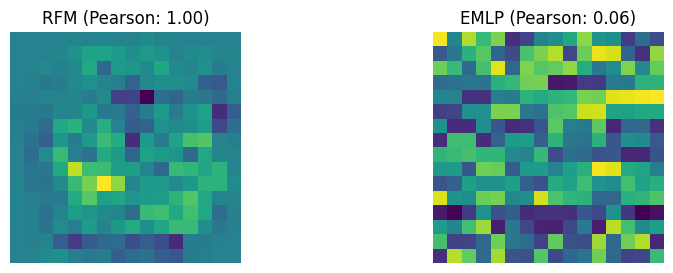

In [24]:
from utils.visualize import visualize_M_dict

e_mlp, _, _, _ = nn.train(
    pos_mnist_trainloader,
    pos_mnist_valloader,
    pos_mnist_testloader,
    model=e_mlp,
    num_epochs=50,
    opt_fn=torch.optim.Adam,
    lr=1e-3,
)
_, emlp_acc = nn.val_step(e_mlp, pos_mnist_testloader)
M_rfm, _, rfm_acc, _ = rfm.train(mnist_trainloader, mnist_testloader, iters=1)
printmd(
    f"RFM acc: {rfm_acc:.2f}% - "
    f"EMLP acc: {emlp_acc:.2f}%, params {sum([p.numel() for p in e_mlp.parameters()])}"
)

M_emlp = e_mlp.network[0].linear.weight.data.detach().cpu().numpy()
M_emlp = M_emlp @ M_emlp.T
P = pearson(M_rfm, M_emlp, eig=True)
_ = visualize_M_dict(
    {
        "RFM": (1.0, M_rfm),
        "EMLP": (P, M_emlp),
    },
    target_plots=["eig"],
    is_pearson=True,
)